In [1]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization

#指定显卡
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [2]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [3]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft = 1024, hop_length = 512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft,
        hop_length = hop_length)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [4]:
def read_data(src_dir, genres, song_samples, spec_format, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_specs = []
    arr_genres = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                signal = signal[:song_samples]
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Convert to dataset of spectograms/melspectograms
                signals, y = splitsongs(signal, genres[x])
                
                # Convert to "spec" representation
                specs = spec_format(signals)
                
                # Save files
                arr_genres.extend(y)
                arr_specs.extend(specs)
                
                
    return np.array(arr_specs), np.array(arr_genres)

In [5]:
# # Parameters
# gtzan_dir = '../data/genres/'
# song_samples = 660000
# genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
#           'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# # Read the data
# X, y = read_data(gtzan_dir, genres, song_samples, to_melspectrogram, debug=False)

In [6]:
# np.save('x_gtzan_npy.npy', X)
# np.save('y_gtzan_npy.npy', y)

In [7]:
# One hot encoding of the labels
X = np.load('x_gtzan_npy.npy')
y = np.load('y_gtzan_npy.npy')
y = to_categorical(y)

# Dataset Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13300, 128, 129, 1) (5700, 128, 129, 1) (13300, 10) (5700, 10)


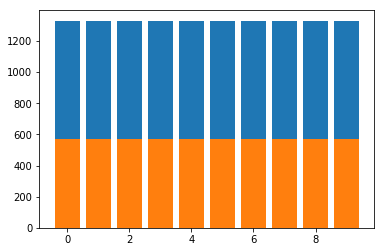

In [10]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# Training

In [11]:
# Model Definition
input_shape = X_train[0].shape
num_genres = 10

model = Sequential()
# Conv Block 1
model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 4
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 5
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
model.add(Dropout(0.25))

# MLP
model.add(Flatten())
model.add(Dense(num_genres, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 127, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
__________

In [12]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 13300 samples, validate on 5700 samples
Epoch 1/50
13300/13300 [==============================] - 12s 907us/step - loss: 2.1161 - acc: 0.2556 - val_loss: 1.8587 - val_acc: 0.2947
Epoch 2/50
13300/13300 [==============================] - 6s 482us/step - loss: 1.6891 - acc: 0.3897 - val_loss: 1.5626 - val_acc: 0.4344
Epoch 3/50
13300/13300 [==============================] - 6s 482us/step - loss: 1.5349 - acc: 0.4553 - val_loss: 1.3784 - val_acc: 0.5074
Epoch 4/50
13300/13300 [==============================] - 6s 479us/step - loss: 1.4116 - acc: 0.5047 - val_loss: 1.3278 - val_acc: 0.5374
Epoch 5/50
13300/13300 [==============================] - 6s 473us/step - loss: 1.3372 - acc: 0.5320 - val_loss: 1.2405 - val_acc: 0.5818
Epoch 6/50
13300/13300 [==============================] - 6s 482us/step - loss: 1.2490 - acc: 0.5701 - val_loss: 1.0711 - val_acc: 0.6540
Epoch 7/50
13300/13300 [==============================] - 6s 481us/step - loss: 1.1980 - acc: 0.5890 - val_loss: 1.0778 - 

In [13]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.511 and val_acc = 0.830


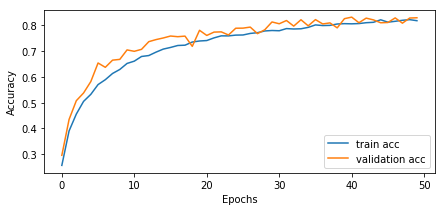

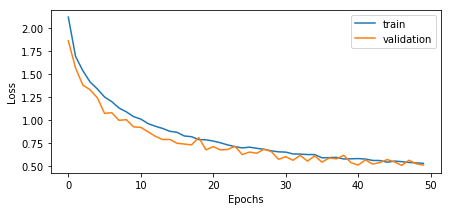

In [14]:
plt.figure(figsize=(7,3))

plt.plot(hist.history['acc'], label='train acc  ')
plt.plot(hist.history['val_acc'], label='validation acc')
# plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(7,3))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
# plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Training and validation accuracy')
plt.legend()

# plt.tight_layout()
plt.show()

In [24]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title)

In [25]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


<Figure size 576x576 with 0 Axes>

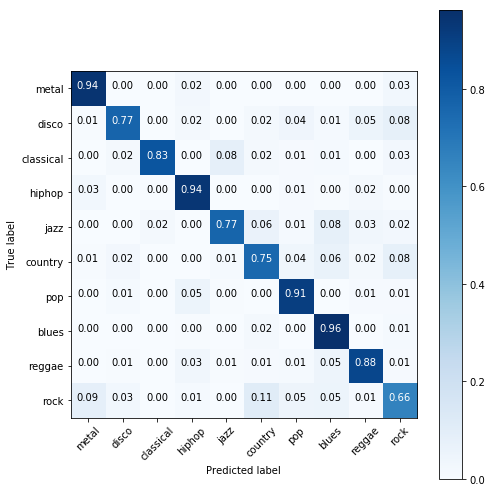

In [26]:
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()


plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

## Save the model

In [22]:
# Save the model
model.save('../models/music1.h5')